In [6]:
# Imports
import torch
from src.utils.data import download_url, unzip_all_files
from src.datasets import BrainTumorDataset, BrainTumorDatasetMask
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [7]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)


Check if data exists on disk
Download completed!
Unzip files
Unzip completed!
Data directory already exists.  if from some reason the data directory structure is wrong please remove the data dir and rerun this script
Data directory already exists.  if from some reason the data directory structure is wrong please remove the data dir and rerun this script


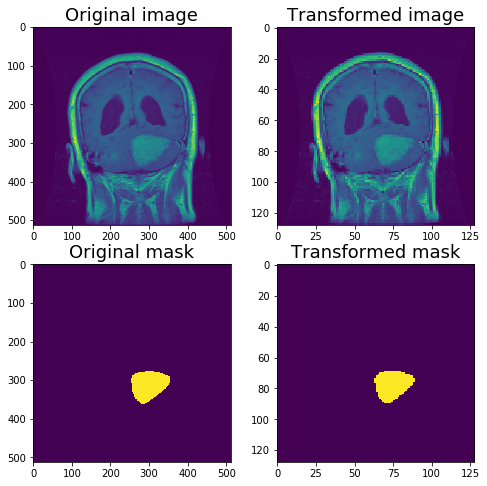

In [8]:
# Download and load data
url = "https://ndownloader.figshare.com/articles/1512427/versions/5"
filename = "all_data.zip"
target_folder = "./data/"
download_url(url, target_folder, filename)
unzip_all_files(target_folder)
def preprocessing(image, mask):
    image_transformer = transforms.Compose([
        transforms.Resize((128,128), interpolation=0),
        transforms.ToTensor()
    ])
    mask_transformer = transforms.Compose([
        transforms.Lambda(lambda x: transforms.ToPILImage()(transforms.ToTensor()(x).float().squeeze())),
        image_transformer
    ])
    return image_transformer(image).float(), mask_transformer(mask).float()

dataset = BrainTumorDatasetMask(root=target_folder,train=True)
original_image , original_mask = dataset[1]
dataset_after_transformation = BrainTumorDatasetMask(root=target_folder,train=True, transform=preprocessing)
image, mask = dataset_after_transformation[1]
visualize(image.squeeze(), mask.squeeze(), original_image, original_mask)

In [2]:
# calculate the mean of the images
loader = DataLoader(
    dataset_after_transformation,
    batch_size=10,
    num_workers=1,
    shuffle=False
)
mean = 0.
std = 0.
nb_samples = 0.
for images, masks in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples
    
mean /= nb_samples
std /= nb_samples
print(mean)
print(std)

NameError: name 'DataLoader' is not defined

3064


2605

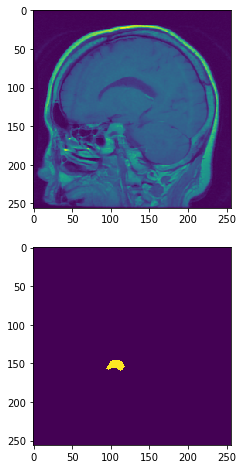

In [5]:
def normalize(x, mean=470., std=None):
    mean_tansor = torch.ones_like(x) * mean
    x -= mean_tansor
    if std:
        x /= std
    return x

def denormalize(x, mean=455.635, std=None):
    mean_tansor = torch.ones_like(x) * mean
    x += mean_tansor
    if std:
        x *= std
    return x


def preprocessing(image, mask):
    mask_transformer = transforms.Compose([
        transforms.Lambda(lambda x: transforms.ToPILImage()(transforms.ToTensor()(x).float().squeeze())),
        transforms.Resize((256,256), interpolation=0),
        transforms.ToTensor()    
    ])
    image_transformer = transforms.Compose([
        transforms.Resize((256,256), interpolation=0),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: normalize(x))
    ])
    return image_transformer(image).float(), mask_transformer(mask).float()

dataset = BrainTumorDatasetMask(root=target_folder,train=True, transform=preprocessing)
image, mask = dataset[6]
visualize(denormalize(image).squeeze(), mask.squeeze())
len(dataset)

In [4]:
import os
import re
import hdf5storage

root='./data/'
items = [item for item in filter(lambda item: re.search("^[0-9]+\.mat$", item), os.listdir(root))]
# Remove files and split files
filtered_items = []
try:
    os.mkdir(root + 'meningioma/')
    os.mkdir(root + 'glioma/')
    os.mkdir(root + 'pituitary/')
except:
    print("Dirs already exists")

for item in items:
    sample = hdf5storage.loadmat(root + item)['cjdata'][0]
    if sample[2].shape[0] == 512:
        if sample[0] == 1:
            os.rename(root + item, root + 'meningioma/' + item)
        if sample[0] == 2:
            os.rename(root + item, root + 'glioma/' + item)
        if sample[0] == 3:
            os.rename(root + item, root + 'pituitary/' + item)
    else:
        os.remove(root + item)

Dirs already exists
